In [1]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from scipy.optimize import curve_fit


In [2]:
def getVbd(df, debug = False):
    # Define the parabolic function
    def par_func(x, a, b, c):
        return a * x**2 + b * x + c
    # Define the linear function
    def lin_func(x, a, b):
        return a * x + b

    x=df.V.to_numpy()
    y=df.I_log.to_numpy()
    if debug:
        plt.plot(x, y, '-')

    Vbr = df['Vbr'].iloc[0]
    x_ = df.query('V>%f & V<%f'%(Vbr-0.1, Vbr+0.5)).V
    y_ = df.query('V>%f & V<%f'%(Vbr-0.1, Vbr+0.5)).I_log

    popt_par, pcov = curve_fit(par_func, x_, y_)
    if debug:
        plt.plot(x, par_func(x, *popt_par), 'r-')

    x_ = df.query('V<%f'%(Vbr-0.25)).V
    y_ = df.query('V<%f'%(Vbr-0.25)).I_log
    popt_lin, pcov = curve_fit(lin_func, x_, y_)
    if debug:
        plt.plot(x_, lin_func(x_, *popt_lin), 'r-')

    finex = np.arange(x.min(), x.max(), 0.01)
    f_par = par_func(finex, *popt_par)
    f_lin = lin_func(finex, *popt_lin)

    idx = np.argwhere(np.diff(np.sign(f_par - f_lin))).flatten()
    return finex[idx].item()

In [3]:
df = pd.DataFrame()
file = 'etc.mu2e.CRV_wideband_cosmics.crviv-000.002500_001.tgz'
Temp = re.split('\.|_',file)[6].lstrip("0")
Temp = float(Temp)/100

with tarfile.open(file, 'r:gz') as tar:
    # Iterate over the files in the archive
    for member in tar.getmembers():
        # Extract the file
        if member.isdir():
            continue
        file = tar.extractfile(member)
        basename = os.path.basename(member.name)
        # Load the extracted file into a pandas DataFrame
        df_ = pd.read_csv(file, skiprows=8, header=0, names = ["V", "I"])  # Assuming the file is in CSV format            
        split_name = basename.split("_")
        fpga = int(split_name[2][4:])
        chan = int(split_name[3][2:])
        df_['fpga'] = fpga
        df_['chan'] = chan + 16*fpga
        df_['I_log'] = np.log(df_['I'])
        df_['Temp'] = Temp
        # Calculate dLod(I)/dV to estimate the breakdown voltage
        df_coarse = df_.groupby(df_.index // 4).mean()
        df_['Vbr'] = df_coarse['V'][df_coarse['I_log'].diff().idxmax()]
        df_['Vbr_fit'] = getVbd(df_)
        df = pd.concat([df,df_], ignore_index=True)

In [4]:
from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

df['rolling_slope'] = df.groupby("chan")['I'].rolling(window=15).apply(get_slope).reset_index(0, drop=True)

Text(0.5, 0, 'V [V]')

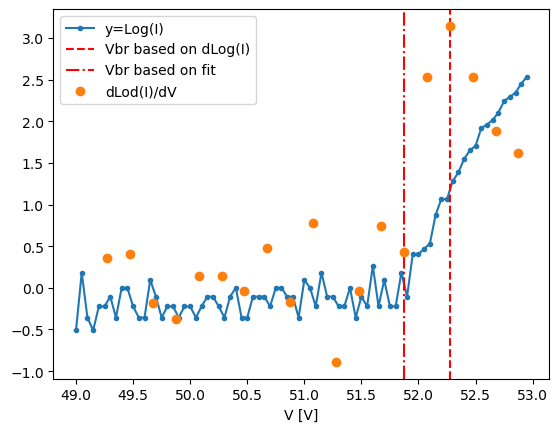

In [14]:
df1 = df.query("chan==6").reset_index()
plt.plot(df1.V, df1.I_log, '.-', label='y=Log(I)');
plt.axvline(x=df1.Vbr[0], color='red', linestyle='--', label='Vbr based on dLog(I)')
plt.axvline(x=df1.Vbr_fit[0], color='red', linestyle='-.', label='Vbr based on fit')

df_coarse = df1.groupby(df1.index // 4).mean()
plt.plot(df_coarse['V'], df_coarse['I_log'].diff()/df_coarse['V'].diff(), 'o', label='dLod(I)/dV')
plt.legend()
plt.xlabel("V [V]")

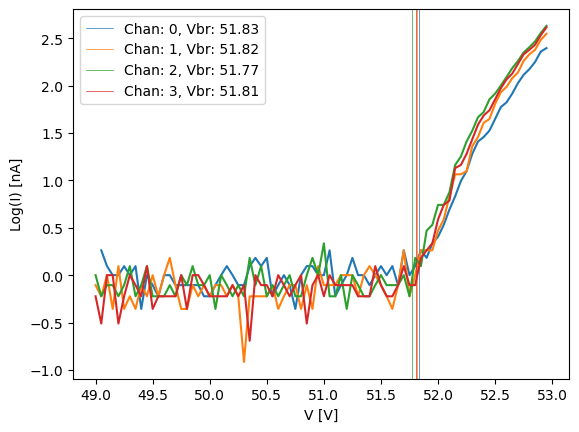

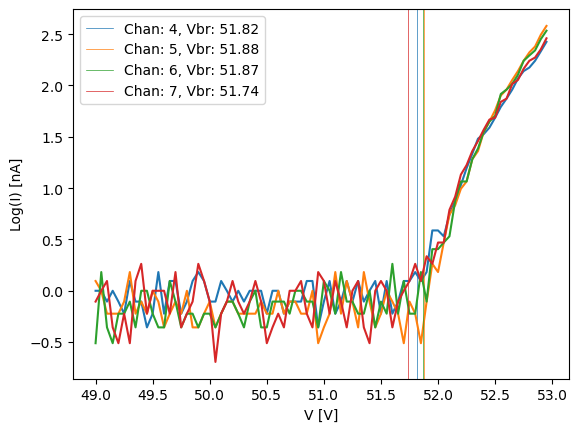

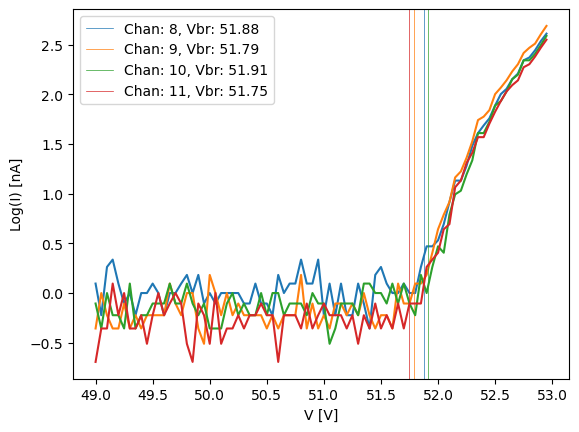

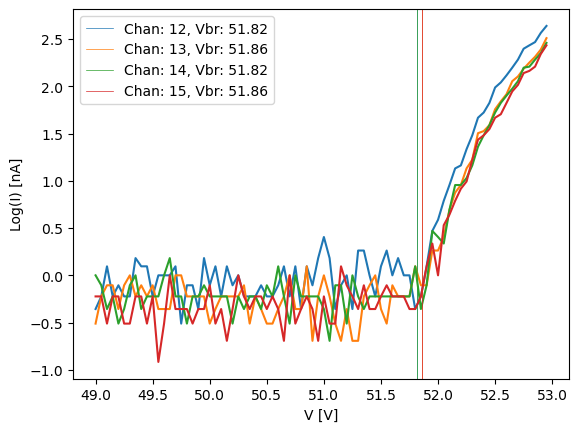

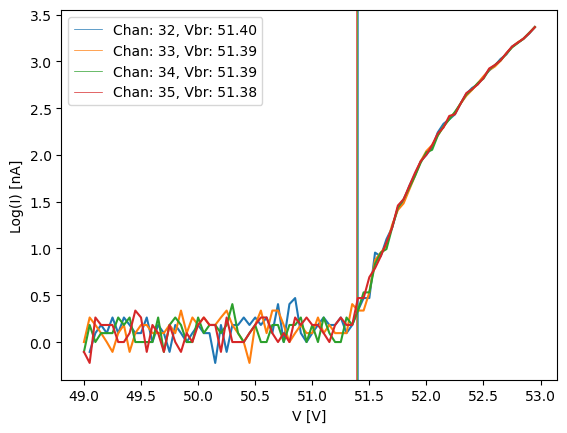

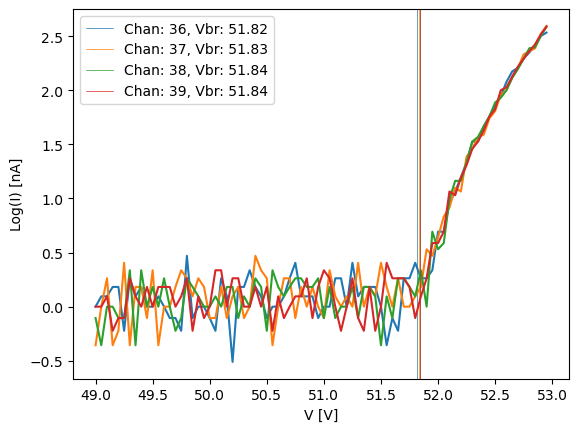

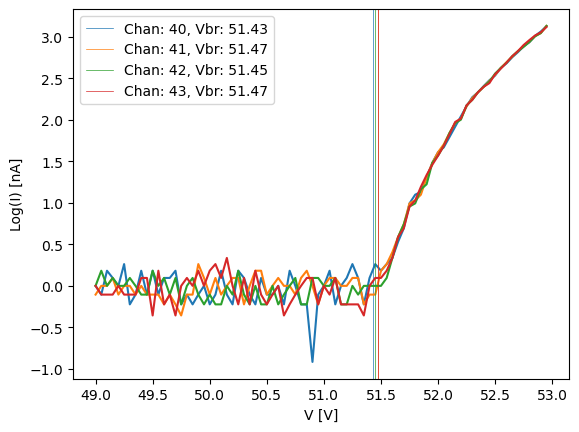

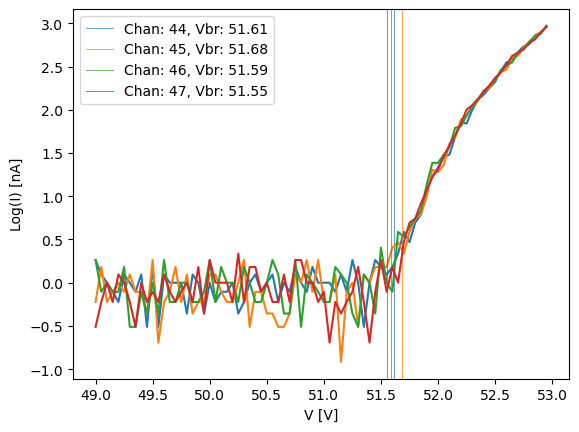

In [9]:
channels = df['chan'].unique()
channels = np.sort(channels)
for chan in channels:
     
    df2 = df.query('chan==%d'%chan)
    Vbr = df2['Vbr_fit'].iloc[0]
     
    if(chan%4 ==0):
        plt.figure()
    plts = plt.plot(df2.V, df2.I_log, '-')
    
    plt.axvline(x=Vbr, linestyle='-', color = plts[0].get_color(), linewidth=0.5,label='Chan: %d, Vbr: %.2f'%(chan, Vbr))
    plt.legend()
    plt.xlabel('V [V]')    
    plt.ylabel('Log(I) [nA]')
